# [과제 3] 로지스틱 회귀분석
### - sklearn 패키지를 사용해 로지스틱 회귀분석을 진행해주세요.
### - 성능지표를 계산하고 이에 대해 해석해주세요.
### - 성능 개선을 시도해주세요. (어떠한 성능지표를 기준으로 개선을 시도했는지, 그 이유도 함께 적어주세요.)
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

## Data 

출처 : https://www.kaggle.com/mlg-ulb/creditcardfraud


* V1 ~ V28 : 비식별화 된 개인정보 
* **Class** : Target 변수  
  - 1 : fraudulent transactions (사기)
  - 0 : otherwise 

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [37]:
data = pd.read_csv("assignment3_creditcard.csv")

In [38]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.848212,2.384900,0.379573,1.048381,-0.845070,2.537837,-4.542983,-10.201458,-1.504967,-2.234167,...,2.585817,-5.291690,0.859364,0.423231,-0.506985,1.020052,-0.627751,-0.017753,0.280982,0
1,2.071805,-0.477943,-1.444444,-0.548657,0.010036,-0.582242,-0.042878,-0.247160,1.171923,-0.342382,...,-0.077306,0.042858,0.390125,0.041569,0.598427,0.098803,0.979686,-0.093244,-0.065615,0
2,-2.985294,-2.747472,1.194068,-0.003036,-1.151041,-0.263559,0.553500,0.635600,0.438545,-1.806488,...,1.345776,0.373760,-0.385777,1.197596,0.407229,0.008013,0.762362,-0.299024,-0.303929,0
3,-1.479452,1.542874,0.290895,0.838142,-0.529290,-0.717661,0.484516,0.545092,-0.780767,0.324804,...,0.038397,0.116771,0.405560,-0.116453,0.541275,-0.216665,-0.415578,0.027126,-0.150347,0
4,-0.281976,-0.309699,-2.162299,-0.851514,0.106167,-1.483888,1.930994,-0.843049,-1.249272,1.079608,...,-0.875516,-0.004199,1.015108,-0.026748,0.077115,-1.468822,0.751700,0.496732,0.331001,0


## EDA

In [39]:
data.isnull().sum()

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
Class    0
dtype: int64

결측치는 없음.

In [40]:
data.shape

(28678, 29)

In [41]:
tmp = data['Class'].value_counts().to_frame().reset_index()
tmp['Percent(%)'] = tmp["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
tmp = tmp.rename(columns = {"index" : "Target", "Class" : "Count"})

tmp

,Target,Count,Percent(%)
0,0,28432,99.14
1,1,246,0.86


총 28,678 건의 데이터 중 246건만이 사기 거래 데이터임을 알 수 있음. 

이는 사기 거래가 정상 거래에 비해 매우 적은 **'Highly unbalanced'**한 특징을 가진 데이터셋임.

이 데이터를 예측 모델 및 분석의 기반으로 사용하면 오류가 많이 발생할 수 있으며 대부분의 트랜잭션이 부정 행위가 아니라고 '가정'하기 때문에 알고리즘이 지나치게 적합할 수 있음.

따라서, 정확도를 기준으로 모델 평기지표를 사용하기보다는 `정밀도`, `재현율` 등의 지표를 개선하고자 함.

## Data Engneering

In [42]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,...,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000
mean,-0.015438,0.053653,-0.046031,0.037348,-0.033724,-0.003299,-0.051054,0.006064,-0.018530,-0.041149,...,0.002633,0.010289,-0.000656,-0.004800,-0.000897,-0.001989,-0.000765,0.000948,0.001535,0.008578
std,2.031529,1.616186,1.758169,1.482109,1.486998,1.339259,1.454827,1.364342,1.134065,1.252593,...,0.720307,0.847152,0.739469,0.593663,0.603349,0.517968,0.483852,0.397075,0.296736,0.092221
min,-30.552380,-42.172688,-31.103685,-5.560118,-42.147898,-21.929312,-41.506796,-39.267378,-13.434066,-24.403185,...,-21.387122,-21.453736,-8.887017,-36.666000,-2.718024,-6.712624,-2.241620,-7.418878,-9.617915,0.000000
25%,-0.916927,-0.575381,-0.899872,-0.843321,-0.714901,-0.763757,-0.568146,-0.206103,-0.661909,-0.543450,...,-0.209678,-0.225520,-0.539244,-0.160583,-0.356047,-0.318619,-0.327343,-0.070558,-0.052189,0.000000
50%,0.020050,0.075358,0.180610,-0.008844,-0.060040,-0.271363,0.036107,0.022463,-0.055095,-0.097390,...,-0.062792,-0.028778,0.007302,-0.011199,0.040006,0.019770,-0.056260,0.002049,0.011075,0.000000
75%,1.317461,0.806957,1.029928,0.771958,0.613328,0.397269,0.559409,0.329606,0.605704,0.460681,...,0.131199,0.184312,0.526358,0.146835,0.437146,0.352717,0.240713,0.091637,0.078911,0.000000
max,2.399484,21.467203,4.069865,11.927512,32.911462,22.529298,36.677268,20.007208,8.113152,15.236028,...,26.237391,27.202839,8.361985,9.637187,3.948061,2.510401,3.122747,11.135740,14.929133,1.000000


비식별화 된 개인정보들의 분포가 일정하지 않음. 

따라서 scaling이 필요하며 Minmax Scaler를 이용함.

In [43]:
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

s_features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)

In [45]:
s_features.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,...,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000
mean,0.926714,0.663520,0.882983,0.320081,0.561078,0.493178,0.530233,0.662568,0.622611,0.614594,...,0.469792,0.449133,0.441133,0.515181,0.791764,0.407605,0.727596,0.417730,0.399891,0.391878
std,0.061651,0.025396,0.049986,0.084752,0.019811,0.030124,0.018608,0.023017,0.052632,0.031600,...,0.084024,0.015125,0.017411,0.042870,0.012821,0.090510,0.056160,0.090197,0.021400,0.012088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.899356,0.653636,0.858708,0.269722,0.552003,0.476073,0.523619,0.658989,0.592752,0.601923,...,0.422444,0.444675,0.436287,0.483957,0.788400,0.354327,0.693265,0.356851,0.396037,0.389689
50%,0.927791,0.663861,0.889427,0.317440,0.560728,0.487149,0.531347,0.662845,0.620914,0.613176,...,0.469277,0.447760,0.440330,0.515643,0.791626,0.413741,0.729955,0.407385,0.399950,0.392267
75%,0.967164,0.675357,0.913573,0.362089,0.569699,0.502188,0.538041,0.668026,0.651582,0.627254,...,0.516566,0.451833,0.444710,0.545734,0.795039,0.473317,0.766055,0.462745,0.404779,0.395030
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [47]:
X_train, X_test, y_train, y_test = train_test_split(s_features, target, test_size=0.2, random_state=10, stratify=target)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22942, 28) (5736, 28) (22942,) (5736,)


In [48]:
pd.DataFrame([[sum(y_train == 0), sum(y_test == 0)], [sum(y_train ==1), sum(y_test == 1)]],
            columns=['train','test'], index=['0 (non-fraud)', '1 (fraud)'])

,train,test
0 (non-fraud),22745,5687
1 (fraud),197,49


## Modeling

In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)
lr_pred = model.predict(X_test)
lr_pred_proba = model.predict_proba(X_test)[:, -1].reshape(-1,1)

## 성능지표

In [50]:
# 오차행렬, 정확도, 정밀도, 재현율을 한 번에 출력하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format( accuracy, precision, recall, f1, roc_auc))

In [51]:
get_clf_eval(y_test, lr_pred, lr_pred_proba)

Confusion Matrix
[[5686    1]
 [  17   32]]
accuracy: 0.9969, precision: 0.9697, recall: 0.6531, f1: 0.7805, roc_auc: 0.9619


정확도와 정밀도는 높으나 재현율이 낮은 양상을 보임.

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_pred).ravel()

p = fn + tp
n = tn + fp

In [53]:
accuracy = (tp + tn) / (p + n)
errorRate = (fn + fp) / (p+n)
recall = (tp) / p
precision = tp/ (tp + fp)
specificity =  tn / (tn + fp)
fpr = fp / n
f1 = f1_score(lr_pred, y_test)

* **Accuracy(정확도)** : 전체 데이터 중에서 맞게 분류된 데이터의 비율
* **Precision(정밀도)** : Positive로 예측한 데이터 중에 실제 positive인 비율
* **Recall(재현율)** : 원래 positive 데이터에서 positive로 분류된 수
* **f1_score** : Recall과 Precision의 조화평균
* **roc_auc** :  AUC는 ROC 곡선 아래의 너비로 1에 가까울수록 좋은 모델임
* **roc_curve** : 모델의 임계값을 조정

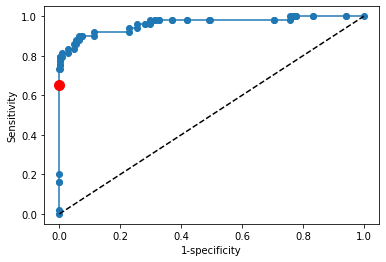

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))

plt.plot(fpr, tpr, 'o-', label="Logistic Regression") 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([1-specificity], [recall], 'ro', ms=10) # 현재 cutoff value 값 
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.show()

현재의 cut-off value값은 최적점이 아님.

`cut-off`는 판단의 가준이 되는 경계임. 이 데이터는 심한 불균형 data set이기에 암으로 예측되는 경우보다는 아닌 경우로 예측할 가능성이 훨씬 큼.

그렇기에 logistic 함수로 구한 성공확률은 기존에 설정한 cut-off값보다 낮을 가능성이 큼. 때문에 우리는 cut-off 값을 낮추어 새로운 값으로 모델을 예측해야 함.

## 성능개선

### cut-off

최적의 cut-off 값은 $(sensitivity) - (1 - specificity) = k$ 일때, 가장 큰 $k$로 정함.

In [55]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

optimal_pred = model.decision_function(X_test) > optimal_threshold

**Confusion Matrix**

In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, optimal_pred).ravel()

p = fn + tp
n = tn + fp

**Accuracy**

In [57]:
accuracy = (tp + tn) / (p + n)
print("Accuracy : ", accuracy) 

Accuracy :  0.9335774058577406


**Precision**

In [58]:
precision = tp / (tp + fp)
print("precision : ", precision)

precision :  0.10287081339712918


cut off 조정 후 낮아진 것을 알 수 있음.

**recall**

In [59]:
recall = (tp) / p
print('Recall : ', recall)

Recall :  0.8775510204081632


cut off 조정 후 높아진 것을 알 수 있음.

**Specificity**

In [60]:
specificity =  tn / (tn + fp)
print("specificity : ", specificity)

specificity :  0.9340601371549148


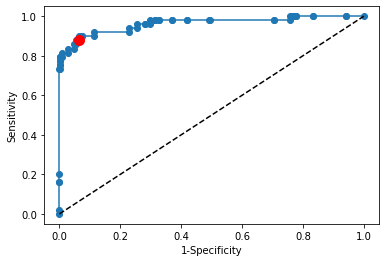

In [61]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, 'o-', label="Logistic Regression") 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([1-specificity], [recall], 'ro', ms=10) # 현재 cutoff value 값 
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

* 개선 전 cut-off는 최적점이 아니었으나, 개선 후에는 최적점에 가깝게 위치가 바뀜
* 재현율이 크게 향상했으나 정밀도가 크게 하락했기에 재현율과 정밀도 사이에는 trade-off관계에 있음을 알 수 있음. FP값이 커졌기에 재현율이 향상되고, FN값이 작아져 정밀도가 하락함.
* 카드 사기 데이터셋은 심장병 예측 데이터 셋과 마찬가지로 재현율이 정밀도보다 중요한 지표임. 정상 거래(질병x)를 사기 거래(질병 O)라고 예측하면 다시 검토(검사)를 통해 해당 예측을 철회할 수 있으나 실제로 사기 거래(질병O)를 정상 거래(질병 x)로 판단하면 큰 손실을 입히기 때문임.
* 따라서 cut-off 조정은 재현율이 크게 개선되었기 때문에 더 나은 방향으로 바뀌었다고 할 수 있음.

### SMOTE 오버 샘플링

In [62]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (22942, 28) (22942,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (45490, 28) (45490,)
SMOTE 적용 후 레이블 값 분포: 
 0    22745
1    22745
Name: Class, dtype: int64


In [63]:
# SMOTE 적용 전 레이블 값 분포
y_train.value_counts()

0    22745
1      197
Name: Class, dtype: int64

In [64]:
model = LogisticRegression()
model.fit(X_train_over, y_train_over)
lr_pred_over = model.predict(X_test)
lr_pred_proba_over = model.predict_proba(X_test)[:, -1].reshape(-1,1)

In [65]:
get_clf_eval(y_test, lr_pred_over, lr_pred_proba_over)

Confusion Matrix
[[5613   74]
 [   7   42]]
accuracy: 0.9859, precision: 0.3621, recall: 0.8571, f1: 0.5091, roc_auc: 0.9696


SMOTE로 오버 샘플링된 데이터로 로지스틱 회귀를 사용해 학습할 경우 재현율이 0.8571로 증가하지만 정밀도가 0.362로 크게 감소함.

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무 많은 class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 class=1로 적용해 정밀도가 급격히 떨어짐.